**DS 301: Applied Data Modeling and Predictive Analysis**

**Lecture 5 – Binary Classification and Performance Measures**

# Binary Classifier with MNIST Dataset

Nok Wongpiromsarn, 8 August 2022

**Credit:** The large portion of the code has been taken from Chapter 3 of Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow

## Get, Visualize, and Prepare the Data for Machine Learning

**Load the mnist handwritten digit dataset**

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [2]:
print(mnist.keys())
print(mnist.DESCR)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a resul

In [3]:
x, y = mnist["data"], mnist["target"]
print(x.shape)
print(y.shape)

(70000, 784)
(70000,)


**Plot the data**

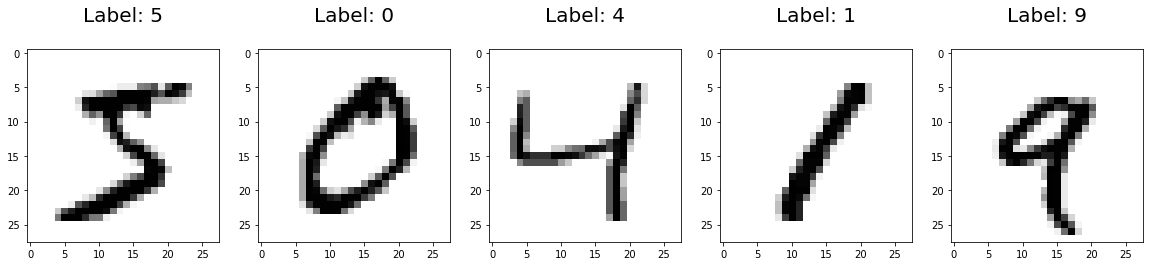

In [4]:
from common_plots import DigitPlotter

num_plots = 5
plotter = DigitPlotter((28, 28))
plotter.is_binary_cm = True
plotter.plot_multiple(x[0:num_plots], y[0:num_plots])

**Convert the target (y) from string to unsigned integer (0 to 255)**

In [5]:
import numpy as np

print(type(y[0]))
y = y.astype(np.uint8)
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


**Split the data into training and testing sets**

In [6]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

## Train a model

**Use linear classifiers with stochastic gradient descent (SGD) training**

In [7]:
# Get the binary target (5 or not 5)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

# some hyperparameters will have a different defaut value in future versions of scikit-Learn, 
# such as max_iter and tol. 
# To be future-proof, we explicitly specify these hyperparameters.
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

## Performance Measures

**1. Training Accuracy**

In [8]:
from sklearn import metrics
y_train_pred = sgd_clf.predict(x_train)
print(metrics.accuracy_score(y_train_5, y_train_pred))

0.9522666666666667


**2. Cross-Validation Accuracy**

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

**3. Confusion Matrix**

In [10]:
# Get the predictions made on each test fold
# With cross_val_predict, the data is split according to the cv parameter.
# Each sample belongs to exactly one test set, and its prediction is computed 
# with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

# Compute the confusion matrix by passing the target (y_train_5)
# and the prediction (y_train_pred)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

**4. Precision, Recall and F1 Score**

In [11]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print("precision: ", precision)
print("recall:    ", recall)

precision:  0.8370879772350012
recall:     0.6511713705958311


In [12]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train_5, y_train_pred)
print("f1 score: ", f1)

f1 score:  0.7325171197343846


Precision/Recall Trade-off

In [13]:
# Use precision_recall_curve to compute precision and recall 
# for all possible thresholds
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, 
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

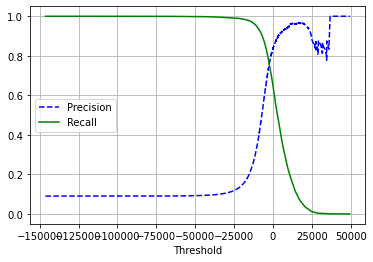

In [14]:
# Plot precision and recall versus the decision threshold
# The length of precisions and the length of recalls is 1 more than that of thresholds.
# The last element of precisions is always 1 and the last element of recalls is always 0.
import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.grid()
plt.legend()
plt.xlabel("Threshold")
plt.show()

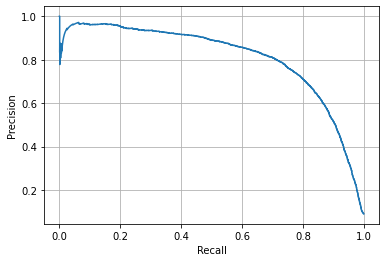

In [15]:
# Plot precision versus recall
plt.plot(recalls, precisions)
plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [16]:
# Get a lowest threshold that gives at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)
precision = precision_score(y_train_5, y_train_pred_90)
recall = recall_score(y_train_5, y_train_pred_90)
print("precision: ", precision)
print("recall:    ", recall)

precision:  0.9000345901072293
recall:     0.4799852425751706


**5. The ROC Curve**

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

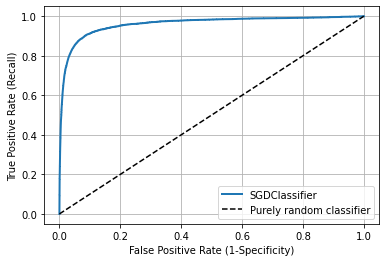

In [18]:
# Plot tpr versus fpr
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, linewidth=2, label="SGDClassifier")
plt.plot([0, 1], [0, 1], 'k--', label="Purely random classifier") # Dashed diagonal
plt.grid()
plt.legend()
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

In [19]:
# Measure the area under the curve (AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616